In [1]:
from pathlib import Path
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.autograd import Variable
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("..")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output_76GDcgx.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


In [2]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    #X_train.append(np.mean(features, axis=0))
    
    X_train.append(features)
    y_train.append([label])
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)



100%|████████████████████████████████████████| 344/344 [00:01<00:00, 280.10it/s]


In [3]:
y_train.shape

(344, 1)

In [4]:

def reduce_y(y):
    y_reduced = list()
    for y_ in y:
        y_reduced.append(np.array([y_[0]]))
    return np.array(y_reduced)


def train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    """
    Split the input data into training, testing, and validation sets
    Args:
        X: input data
        y: labels
        train_size: proportion of data to be used for training
        val_size: proportion of data to be used for validation
        test_size: proportion of data to be used for testing
        random_state: seed for random number generator
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    np.random.seed(random_state)
    n_samples = X.shape[0]
    idx = np.random.permutation(n_samples)
    X, y = X[idx], y[idx]
    train_end = int(train_size * n_samples)
    val_end = int((train_size + val_size) * n_samples)
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, X_val, X_test, reduce_y(y_train), reduce_y(y_val), reduce_y(y_test)


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_train, y_train, train_size=0.8, val_size=.2, test_size=0)



In [5]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)

In [6]:
X_train.squeeze(0).shape

torch.Size([275, 1000, 2048])

fe_1(

Their tiles : 16x128x128

ours : 1000x2048

##### Them:

16x128x128x3 -> FA2 & FA2 -> 512,1 ->

In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn 


class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.L = 2048 # 512 node fully connected layer
        self.D = 16 # 128 node attention layer
        self.K = 1
        
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Linear(self.D, self.K),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.squeeze(0)

        H = x #self.L
        A = self.attention(H) # NxK
        A = torch.transpose(A, 1, 0) # KxN
        A = F.softmax(A, dim=1) # softmax over N
        M = torch.mm(A, H)
       # The probability that a given bag is malignant or benign
        Y_prob = self.classifier(M) 
        # The prediction given the probability (Y_prob >= 0.5 returns a Y_hat of 1 meaning malignant)
        Y_hat = torch.ge(Y_prob, 0.5).float()
        return Y_prob, Y_hat, A.byte()
    
    
    
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))

        return neg_log_likelihood, A

In [8]:

def train(model,X_train,y_train, optimizer, epoch):
    model.train()
    train_loss = 0.
    train_error = 0.
    predictions = []
    labels = []
    
    for bag_idx,x in enumerate(X_train):
        bag_label = y_train[bag_idx]
        
        #for idx,data in enumerate(x): #de 0 à 1000
        #data = torch.squeeze(data) #a voir
            
        data = torch.squeeze(x)    
        
        data, bag_label = Variable(data), Variable(bag_label)


        # Reset gradients
        optimizer.zero_grad()
        # Calculate loss
        loss, attention_weights = model.calculate_objective(data, bag_label)
        train_loss += loss.data[0]
        # Calculate error
        error, predicted_label = model.calculate_classification_error(data, bag_label)
        train_error += error

        # Keep track of predictions and labels to calculate accuracy after each epoch
        _, Y_hat, _ = model(data)
        predictions.append(int(Y_hat)) 
        labels.append(int(bag_label))
        # Backward pass
        loss.backward()
        # Update model weights
        optimizer.step()
    train_loss /= len(X_train)
    train_error /= len(X_train)
    
    #metric = accuracy_score(labels, predictions)*100
    metric = roc_auc_score(labels, predictions)*100
    
    print('Train Set, Epoch: {}, Loss: {:.4f}, Error: {:.4f}, ROC AUC: {:.2f}%'.format(epoch, train_loss.cpu().numpy()[0], train_error,metric))

    return train_loss,metric



In [9]:
def test(model,X_val,y_val):
    model.eval()
    test_loss = 0.
    test_error = 0.
    
    labels = list()
    predictions=list()
    
    with torch.no_grad():
        
        for bag_idx,x in enumerate(X_val):
            bag_label = y_train[bag_idx]
            data = torch.squeeze(x) 
            data, bag_label = Variable(data), Variable(bag_label)


            loss, attention_weights = model.calculate_objective(data, bag_label)
            test_loss += loss.data[0]
            error, predicted_label = model.calculate_classification_error(data, bag_label)
            
            # Keep track of predictions and labels to calculate accuracy after each epoch
            _, Y_hat, _ = model(data)
            predictions.append(int(Y_hat)) 
            labels.append(int(bag_label))
            test_error += error
        
        test_error /= len(X_val)
        test_loss /= len(X_val)
            

        
        
        metric = roc_auc_score(labels,predictions)*100
        print('Val Set, Loss: {:.4f}, Error: {:.4f}, ROC AUC: {:.2f}'.format(test_loss.cpu().numpy()[0], test_error, metric))
        print('=====================================================================================')
    return test_loss,metric

In [10]:
y_train.shape

torch.Size([275, 1])

In [ ]:
model = Attention()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)

print('Start Training')

history_train, history_val = list(),list()

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    history_train += train(model, X_train,y_train, optimizer, epoch)
    history_val   += test(model, X_val, y_val)


Start Training
Train Set, Epoch: 1, Loss: 0.6813, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6757, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 2, Loss: 0.6749, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6687, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 3, Loss: 0.6695, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6626, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 4, Loss: 0.6649, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6574, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 5, Loss: 0.6609, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6529, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 6, Loss: 0.6575, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6491, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 7, Loss: 0.6546, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6457, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 8, Loss: 0.6520, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6428, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 9, Loss: 0.6498

Train Set, Epoch: 41, Loss: 0.6243, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6220, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 42, Loss: 0.6238, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6220, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 43, Loss: 0.6230, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6220, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 44, Loss: 0.6225, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6219, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 45, Loss: 0.6220, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6219, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 46, Loss: 0.6215, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6219, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 47, Loss: 0.6208, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6219, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 48, Loss: 0.6205, Error: 0.3418, ROC AUC: 50.00%
Val Set, Loss: 0.6219, Error: 0.3043, ROC AUC: 50.00
Train Set, Epoch: 49, Loss: 0.6199, Erro

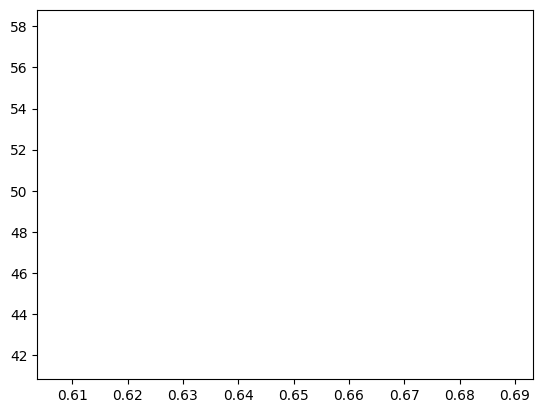

In [165]:
plt.plot(history_train)

In [ ]:
save_model(model, args.model_dir)